# Jax Parallelization Tricks


While differentiability is a great reason to use JAX, arguably
its APIs for parallelization are an equally good reason

In standard..


## An Example

Let's say you have a function computing something
interesting for some inputs `x`.

For example we can use the text book definition
of a dense layer in a neural network

$$y = W x + b$$

or written with indices: 

$$y_{i} = W_{ij} x_{j} + b_{i}$$



In [90]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


def dense_layer(x):
    W = jnp.array([[0.2,0.4],[0.9,0.2]])
    b = jnp.array([0.2,0.3])
    return W.dot(x) + b

inputs = jnp.array([1.1,1.2])
out = dense_layer(inputs)
print(f'{inputs} -> {out}')

[1.1 1.2] -> [0.90000004 1.53      ]


But in practice we always want to evaluate on a mini-batch of $x$ with a batch dimension

$$x = x_{bi}$$

The linear layer would thus be in index-notation

$$y_{bi} = W_{ij} x_{bj} + b_{i}$$

but this is not compatible with our code `W.dot(x)` above as the batch index 
is in the way

In [28]:
inputs = jnp.array([
    [1.1,1.2],
    [2.1,2.2],
    [3.1,3.2]

])

try:
    dense_layer(inputs)
except TypeError as exc:
    print(exc)

Incompatible shapes for dot: got (2, 2) and (3, 2).


## Workarounds

### Einsums

We can work around it by adjusting our dense layer code and using `einsum` tricks
to incorporate the new batch dimension:

In [44]:
def einsum_layer(x):
    W = jnp.array([[0.2,0.4],[0.9,0.2]])
    b = jnp.array([0.2,0.3])
    return jnp.einsum('ij,bj->bi',W,x) + b

einsum_layer(inputs)

DeviceArray([[0.90000004, 1.53      ],
             [1.5000001 , 2.6299999 ],
             [2.1000001 , 3.7299998 ]], dtype=float32)

## Transposition

Another workaround you'll see frequently in textbooks is to interchange
the order of `W` and `b` such that the batch dimension is "up front" and
won't be in the way

$$ y = xW^T + b $$

which with indices looks like

$$ y = x_{bj}W^T_{ji} + b_{i} = W_{ij}x_{bj} + b_{i}$$


This works, but also at the cost of changing code to accomodate "batching"


In [45]:
def transpose_layer(x):
    W = jnp.array([[0.2,0.4],[0.9,0.2]])
    b = jnp.array([0.2,0.3])
    return x.dot(W.T) + b


transpose_layer(inputs)

DeviceArray([[0.90000004, 1.53      ],
             [1.5000001 , 2.6299999 ],
             [2.1000001 , 3.7299998 ]], dtype=float32)

## The JAX Way:

In JAX, batching could not be easier!

There is no change in the code, but you just apply a 
batching function to it to receive a "batched" version of it

In [48]:
batched_dense = jax.vmap(dense_layer)
batched_dense(inputs)

DeviceArray([[0.90000004, 1.53      ],
             [1.5000001 , 2.6299999 ],
             [2.1000001 , 3.7299998 ]], dtype=float32)

# Handling multiples inputs

Sometimes you have more than one inputs to a function 

$$ f = f(x,y) $$

and for such functions some more information must be provided
as to how batching should take place

## Zipping

When zipping a function we want both arguments to be iterated "in lock-step"

In standard Python it would look something like this:

`out = [f(x[i],x[i]) for zip(x,y)]`

In JAX, we give that batch-dimension of each argument (here: 0) via the `in_axes` argument

In [71]:
def func(x,y):
    return x+y

x_batched = jnp.array([1,2,3])
y_batched = jnp.array([4,5,6])
jax.vmap(func, in_axes = (0,0))(x_batched,y_batched)

DeviceArray([5, 7, 9], dtype=int32)

## Non-leading Batch dimensions

It can happen that your batch dimension for the various arguments differ

for example for

```
x = [[1,2,3]] #shape (1,3)
y = [[4],[5],[6] #shape (3,1)
```

In this case our Python code would look like

`out = [f(x[0][i],x[i][0]) for zip(x,y)]`

That is for `x` the batch dimension is the second (i.e. idx = 1, starting from 0) dimension
of the array.

For `y` it's the first dimension of the array (i.e. idx=0)

We can communicate this to JAX by specifying where the batch dimensions are
for the inputs and also where we want the batch dimension to be for the output

In [72]:
x_batched = jnp.array([[1,2,3]])
y_batched = jnp.array([[4],[5],[6]])
out1 = jax.vmap(func, in_axes = (1,0), out_axes=1)(x_batched,y_batched)
print(out1)
print(out1.shape) #batch dimension of size 3 at second position (idx 1)

[[5 7 9]]
(1, 3)


In [73]:
out2 = jax.vmap(func, in_axes = (1,0), out_axes=0)(x_batched,y_batched)
print(out2)
print(out2.shape)  #batch dimension of size 3 at first position (idx 0)

[[5]
 [7]
 [9]]
(3, 1)


## Un-batched dimensions

You can also have un-batched dimensions that just "go along for the ride"

e.g.

```
x = 3.0
out = [f(x,y) for y in range(..)]
```

In JAX by passing `None`

In [77]:
def func(x,y):
    return x*y

jax.vmap(func, in_axes = (None,0))(3.0,jnp.array([3,4,5]))

DeviceArray([ 9., 12., 15.], dtype=float32, weak_type=True)

## Composition and Cartesian Products

For a function $f(x,y)$ you may want to evalute it on a "grid"


```
x = 3.0
out = [f(x[i],y[j]) for i,j in cartesian_product(...)]
```

by applying `vmap` multiple times

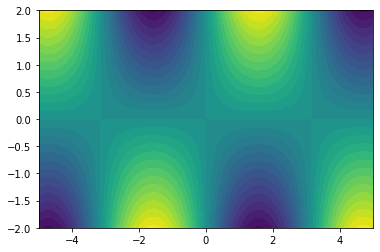

In [99]:
x_range = jnp.linspace(-5,5)
y_range = jnp.linspace(-2,2)

def func(x,y):
    return jnp.sin(x)*y

out = jax.vmap(jax.vmap(func, in_axes = (None,0)), in_axes = (0,None))(x_range,y_range)

grid = jnp.meshgrid(x_range,y_range, indexing = 'ij')
plt.contourf(grid[0],grid[1],out, levels = 31)